In [22]:
import pandas as pd 
from pyspark.sql import functions as F 
from pyspark.sql.functions import sum, col, datediff, current_date,\
when,countDistinct
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

/home/coder/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
#pyspark intilization
spark = SparkSession.builder.appName("Cumulative Activity").getOrCreate()

spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/05 22:20:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/12/05 22:20:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
#read CSV
sal_df = spark.read.csv("updated_salaries.csv",header = "True", inferSchema = True)
sal_df.show(5)
sal_df.printSchema()

+------+------+-------+----------+----------+
|emp_no|salary|dept_no| from_date|   to_date|
+------+------+-------+----------+----------+
| 10017| 71380|   d001|1993-08-03|1994-08-03|
| 10017| 75538|   d001|1994-08-03|1995-08-03|
| 10017| 79510|   d001|1995-08-03|1996-08-02|
| 10017| 82163|   d001|1996-08-02|1997-08-02|
| 10017| 86157|   d001|1997-08-02|1998-08-02|
+------+------+-------+----------+----------+
only showing top 5 rows

root
 |-- emp_no: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_no: string (nullable = true)
 |-- from_date: date (nullable = true)
 |-- to_date: date (nullable = true)



In [14]:
#calculate the years worked 
sal_df.printSchema()
sal_df = sal_df.withColumn("to_date",when(col("to_date")=="9999-01-01",current_date())\
                           .otherwise(col("to_date")))
sal_df = sal_df.withColumn("Years worked",F.year(col("to_date")) - F.year(col("from_date")))
sal_df.show(5)

sal_df_agg = sal_df.groupBy(["emp_no","dept_no"]).agg(
        sum("Years worked").alias("Total Years worked")).orderBy(col("emp_no"))
sal_df_agg.show(5)

root
 |-- emp_no: integer (nullable = true)
 |-- salary: integer (nullable = true)
 |-- dept_no: string (nullable = true)
 |-- from_date: date (nullable = true)
 |-- to_date: date (nullable = true)
 |-- Years worked: integer (nullable = true)

+------+------+-------+----------+----------+------------+
|emp_no|salary|dept_no| from_date|   to_date|Years worked|
+------+------+-------+----------+----------+------------+
| 10017| 71380|   d001|1993-08-03|1994-08-03|           1|
| 10017| 75538|   d001|1994-08-03|1995-08-03|           1|
| 10017| 79510|   d001|1995-08-03|1996-08-02|           1|
| 10017| 82163|   d001|1996-08-02|1997-08-02|           1|
| 10017| 86157|   d001|1997-08-02|1998-08-02|           1|
+------+------+-------+----------+----------+------------+
only showing top 5 rows



+------+-------+------------------+
|emp_no|dept_no|Total Years worked|
+------+-------+------------------+
| 10001|   d005|                39|
| 10002|   d007|                29|
| 10003|   d004|                30|
| 10004|   d004|                39|
| 10005|   d003|                36|
+------+-------+------------------+
only showing top 5 rows



In [15]:
#filter employees worked more than 10 years

sal_df_agg  = sal_df_agg.filter(col("Total Years worked")>10)
sal_df_agg.show(10)



+------+------+-------+----------+----------+------------+
|emp_no|salary|dept_no| from_date|   to_date|Years worked|
+------+------+-------+----------+----------+------------+
| 10017| 71380|   d001|1993-08-03|1994-08-03|           1|
| 10017| 75538|   d001|1994-08-03|1995-08-03|           1|
| 10017| 79510|   d001|1995-08-03|1996-08-02|           1|
| 10017| 82163|   d001|1996-08-02|1997-08-02|           1|
| 10017| 86157|   d001|1997-08-02|1998-08-02|           1|
| 10017| 89619|   d001|1998-08-02|1999-08-02|           1|
| 10017| 91985|   d001|1999-08-02|2000-08-01|           1|
| 10017| 96122|   d001|2000-08-01|2001-08-01|           1|
| 10017| 98522|   d001|2001-08-01|2002-08-01|           1|
| 10017| 99651|   d001|2002-08-01|2025-12-05|          23|
+------+------+-------+----------+----------+------------+



+------+-------+------------------+
|emp_no|dept_no|Total Years worked|
+------+-------+------------------+
| 10017|   d001|                32|
+------+-------+------------------+



In [21]:
#distinct Emps in each dept that worked more than 5 years
sal_df_agg_gt5 = sal_df_agg.filter(col("Total Years worked")>5)
sal_data = sal_df_agg_gt5.groupBy("dept_no")\
    .agg(
        countDistinct("emp_no").alias("Unique Emps")
    )
sal_data.show()


+-------+-----------+
|dept_no|Unique Emps|
+-------+-----------+
|   d005|      23863|
|   d009|       4822|
|   d003|       5048|
|   d001|       5583|
|   d007|      14537|
|   d004|      20580|
|   d002|       4828|
|   d006|       5549|
|   d008|       5886|
+-------+-----------+



Unique emps: 100412


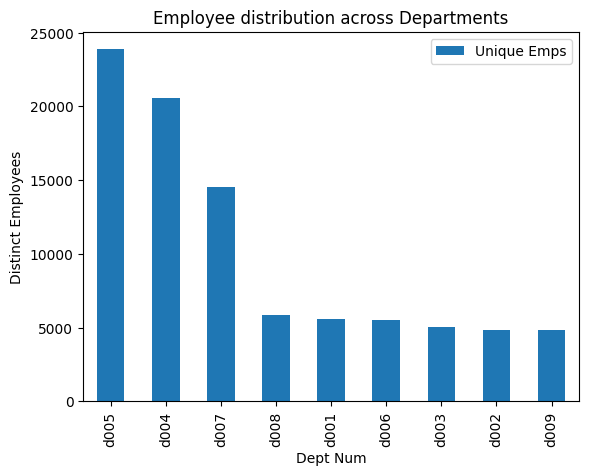

In [24]:
#create a barchart to visualize the distribution of employees worked 
#over 5 years across different dept 

sal_data_pandas = sal_data.toPandas()
sal_data_pandas = sal_data_pandas.sort_values(by="Unique Emps", ascending = False)

sal_data_pandas.plot(kind = "bar",x="dept_no",y="Unique Emps")
plt.title("Employee distribution across Departments")
plt.xlabel("Dept Num")
plt.ylabel("Distinct Employees")
plt.show()

